### Исследование зарплат в России за октябрь в России

Цель данной работы: статистически проанализировать данные о заработной в плате в России за конкретный месяц (октябрь 2019 года).

Автор: Копыл Роман

In [185]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, lognorm
np.random.seed(42)

1. Загрузим датасет с информацией о средних заработных платах по каждому региону России за октябрь 2019 года.

In [295]:
salaries = pd.read_excel('data_stat.xlsx', sheet_name='Зарплаты', index_col=0, usecols=[0,10])
salaries.rename(columns={'октябрь': 'Средняя з/п (10.2019)'}, inplace=True)
salaries.head()

,Средняя з/п (10.2019)
Субъект России,
Алтайский край,28265.5
Амурская область,48242.3
Архангельская область,48515.3
Астраханская область,34601.4
Белгородская область,35324.3


2. Загрузим датасет с данными о населении каждого региона на 1 января 2019 года. Будем считать, что население изменилось не значительно и изменения не повлияют на результаты исследования.

In [18]:
population = pd.read_excel('data_stat.xlsx', sheet_name='Население', index_col=0)
population.head()

,Население (01.01.2019)
Субъект России,
Алтайский край,2332813
Амурская область,793194
Архангельская область,1144119
Астраханская область,1014065
Белгородская область,1547418


3. Найдем медиану, среднее значение и стандартное отклонение средних зарплат по регионам

In [291]:
med0 = salaries.median().values[0]
print('Медианное значение средних зарплат по регионам: ' + str(med) + ' рублей')

mean0 = salaries.mean().values[0]
print('Среднее значение средних зарплат по регионам: ' + str(round(mean0,1)) + ' рубля')

std0 = salaries.std().values[0]
print('Стандартное отклонение средних зарплат по регионам: ' + str(round(std0,1)) + ' рублей')

Медианное значение средних зарплат по регионам: 35324.3 рублей
Среднее значение средних зарплат по регионам: 41264.0 рубля
Стандартное отклонение средних зарплат по регионам: 16831.3 рублей


4. Построим график распределения средних зарплат по регионам

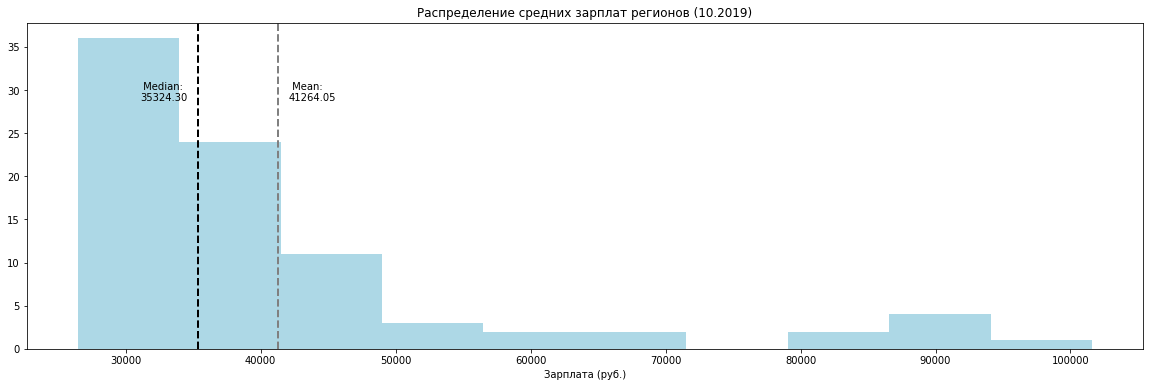

In [396]:
plt.figure(figsize=(20,6))

plt.hist(salaries.values, color='lightblue')
plt.axvline(med0, color='k', linestyle='dashed', linewidth=2)
plt.axvline(mean0, color='gray', linestyle='dashed', linewidth=2)

min_ylim, max_ylim = plt.ylim()
plt.text(mean0*1.02, max_ylim*0.76, ' Mean:\n{:.2f}'.format(mean0))
plt.text(med0*0.88, max_ylim*0.76, ' Median:\n{:.2f}'.format(med0), color='black')
plt.xlabel('Зарплата (руб.)')
plt.title('Распределение средних зарплат регионов (10.2019)');

5. Построим эмпирическую функцию распределения средних зарплат по регионам

In [391]:
salaries_values = []
for i, j in zip(salaries.values.flatten(), population.values.flatten() // 10000):
    salaries_values += [i] * 1
salaries_values = pd.Series(salaries_values)

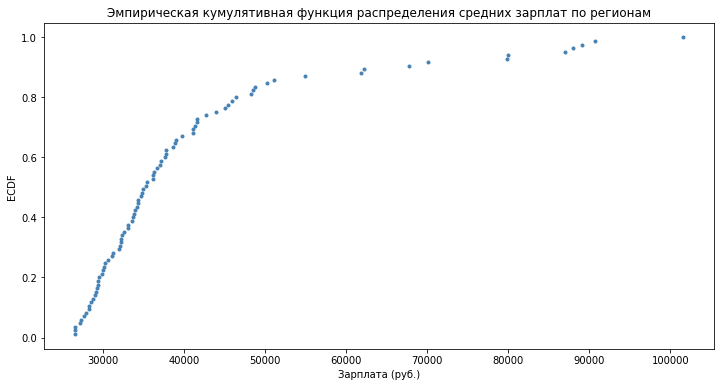

In [395]:
x, y = ecdf(salaries_values)

# Generate plot
plt.figure(figsize=(12,6))
plt.plot(x, y, marker='.', linestyle= 'none', color='steelblue')

# Label the axes
plt.xlabel('Зарплата (руб.)')
plt.ylabel("ECDF")
plt.title('Эмпирическая кумулятивная функция распределения средних зарплат по регионам')

# Display the plot
plt.show();

6. Отметим, что на предыдущих этапах наблюдения были некорректны, так как каждое значение средней зарплаты имело в нашей выборке одинаковый вес, но в реальности у регионов разное население, что вносит свой вклад в общее распределение зарплаты в стране. Логично было бы, чтобы веса среднейй зарплаты задавались бы населением региона. Но давайте пойдем дальше и смоделируем возможные зарплаты. Как мы часто слышали, распределение зарплат соответствует нормальному распределению, скошенному в сторону меньших значений. Поэтому для каждого региона я сгененирую набор значений возможных заработных плат, соответствующий нормальному распределению со средним, равным средней зарплате по региону и коэффициенту ассиметрии, равному 2.5. В качестве стандартного отклонения возьмем половину стандартного отклонения выборки средних зарплат, добавив, что я предполагаю, что стандартное отклонение по средним регионов является верхней границей оценки этого параметра для всех зарплат по стране, а страты, которые представляют из себя множества зарплат, соответствующие жителям одного региона, имеют дисперсию меньше, чем дисперсия по стране. То есть, мы пользуемся верхней оценкой дисперсии внутри группы.

Итак, для начала сгенерируем выборку из смоделированных значений.

In [195]:
#Initilize functions generating items frow skewed normal distributions

def rand_skew_norm(alpha, loc, scale):
    sigma = alpha / np.sqrt(1.0 + alpha ** 2) 

    u0, v = np.random.randn(2)
    u1 = sigma * u0 + np.sqrt(1.0 - sigma ** 2) * v 

    if u0 >= 0:
        return u1 * scale + loc 
    
    return (-u1) * scale + loc 

def randn_skew(N, skew, mean, std):
    skew_list = []
    for _ in range(N):
        skew_list += list(rand_skew_norm(skew, mean, std))
    return skew_list

In [382]:
salaries_full = [] 
for i, j in zip(salaries.values.flatten(), population.values.flatten() // 10000):
    salaries_full += randn_skew(j, -10, i, salaries.std()/2)
salaries_full = pd.Series(salaries_full)

7. Выведем основные характеристики новых данных

In [383]:
med1 = salaries_full.median()
print('Медианное значение смоделированных зарплат по России: ' + str(round(med1,1)) + ' рублей')

mean1 = salaries_full.mean()
print('Среднее значение смоделированных зарплат по России: ' + str(round(mean1,1)) + ' рублей')

std1 = salaries_full.std()
print('Стандартное отклонение средних зарплат по регионам: ' + str(round(std1,1)) + ' рублей')

Медианное значение смоделированных зарплат по России: 31966.9 рублей
Среднее значение смоделированных зарплат по России: 37151.3 рублей
Стандартное отклонение средних зарплат по регионам: 17992.8 рублей


8. Построим график распределения смоделированных средних зарплат по стране

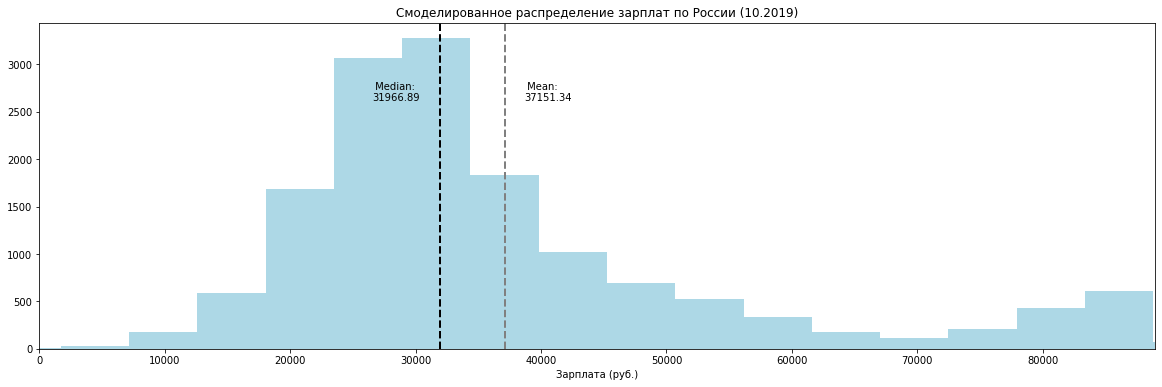

In [394]:
plt.figure(figsize=(20,6))

plt.hist(salaries_full.values, color='lightblue', bins=20)
plt.axvline(med1, color='k', linestyle='dashed', linewidth=2)
plt.axvline(mean1, color='gray', linestyle='dashed', linewidth=2)

plt.xlim(left=0, right=89000)
min_ylim, max_ylim = plt.ylim()
plt.text(mean1*1.04, max_ylim*0.76, ' Mean:\n{:.2f}'.format(mean1))
plt.text(med1*0.83, max_ylim*0.76, ' Median:\n{:.2f}'.format(med1))
plt.xlabel('Зарплата (руб.)')
plt.title('Смоделированное распределение зарплат по России (10.2019)');

9. Построим функцию эмпирического распределения зарплат

In [58]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

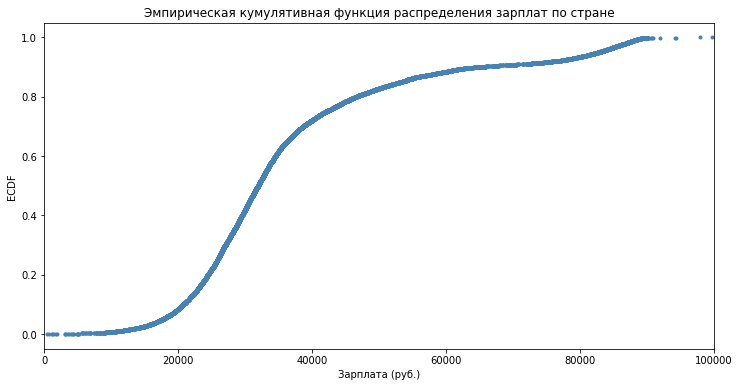

In [393]:
x, y = ecdf(salaries_full)

# Generate plot
plt.figure(figsize=(12,6))
plt.plot(x, y, marker='.', linestyle= 'none', color='steelblue')

# Label the axes
plt.xlabel('Зарплата (руб.)')
plt.ylabel("ECDF")
plt.title('Эмпирическая кумулятивная функция распределения зарплат по стране')

# Display the plot
plt.xlim(left=0, right=100000)
plt.show();

10. Как мы получили, несмотря на то, что основные характеристики, выявленные из данных о средних зарплатах и из симулированных данных примерно одинаковые, распределение из симулированных данных более похоже на настоящее, хотя все ещё имеет отрезки, которые оставляют вопросы. Например, возможно ли такая большая доля людей со сверхвысокими доходами. Но это уже выходит за рамки исследования.